In [2]:
import json
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

### Load data

In [55]:
data=pd.read_csv(r"C:\Users\Lawye\YandexDisk\jupyter\hackaton\results_bes_pervonachalnyx_s_kartinkoy.csv", encoding='utf-8')
data.head(3)

,Unnamed: 0,target,unique,variantid1,variantid2,Count_vec Similarity_characteristic_attributes_mapping,TF-idf Similarity_characteristic_attributes_mapping,Count_vec Similarity_name,TF-idf Similarity_name,Count_vec Similarity_categories,TF-idf Similarity_categories,Count_vec Similarity_color_parsed,TF-idf Similarity_color_parsed,Count_vec Similarity_all_text,TF-idf Similarity_all_text,cos_sim_main_pic_embeddings_resnet
0,0,0.0,5119786251198054,51197862,51198054,1.000000,1.000000,0.857143,0.752320,1.0,1.0,1.0,1.0,0.989796,0.980042,0.999613
1,1,0.0,5119786251199884,51197862,51199884,1.000000,1.000000,0.857143,0.752320,1.0,1.0,1.0,1.0,0.989796,0.980042,0.999544
2,2,1.0,53062686536165289,53062686,536165289,0.416667,0.311807,0.750000,0.602975,1.0,1.0,0.0,0.0,0.583805,0.439611,0.987629


In [56]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306540 entries, 0 to 306539
Data columns (total 6 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unnamed: 0                           306540 non-null  int64  
 1   unique                               306540 non-null  int64  
 2   similarity_pic_embeddings_resnet_v1  306540 non-null  float64
 3   similarity_name_bert_64              306540 non-null  float64
 4   cat3                                 306540 non-null  object 
 5   cat3_grouped                         306540 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 14.0+ MB


In [57]:
data2 = pd.read_csv(r"C:\Users\Lawye\YandexDisk\jupyter\hackaton\results_image_add_bert_end.csv", encoding ='utf-8')
data2.head(1)

,Unnamed: 0,unique,similarity_pic_embeddings_resnet_v1,similarity_name_bert_64,cat3,cat3_grouped
0,0,5119786251198054,0.999613,0.996394,"Сетевые фильтры, разветвители и удлинители","Сетевые фильтры, разветвители и удлинители"


In [58]:
copydata = data.merge(data2, left_on = 'unique', right_on = 'unique', how = 'inner')

In [59]:
copydata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306540 entries, 0 to 306539
Data columns (total 21 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   Unnamed: 0_x                                            306540 non-null  int64  
 1   target                                                  306540 non-null  float64
 2   unique                                                  306540 non-null  int64  
 3   variantid1                                              306540 non-null  int64  
 4   variantid2                                              306540 non-null  int64  
 5   Count_vec Similarity_characteristic_attributes_mapping  306540 non-null  float64
 6   TF-idf Similarity_characteristic_attributes_mapping     306540 non-null  float64
 7   Count_vec Similarity_name                               306540 non-null  float64
 8   TF-idf Similarity_name  

In [60]:
copydata["target"].value_counts()

0.0    171527
1.0    135013
Name: target, dtype: int64

Choose features

In [61]:
features = copydata.copy()

In [62]:
features.head(5)

,Unnamed: 0_x,target,unique,variantid1,variantid2,Count_vec Similarity_characteristic_attributes_mapping,TF-idf Similarity_characteristic_attributes_mapping,Count_vec Similarity_name,TF-idf Similarity_name,Count_vec Similarity_categories,...,Count_vec Similarity_color_parsed,TF-idf Similarity_color_parsed,Count_vec Similarity_all_text,TF-idf Similarity_all_text,cos_sim_main_pic_embeddings_resnet,Unnamed: 0_y,similarity_pic_embeddings_resnet_v1,similarity_name_bert_64,cat3,cat3_grouped
0,0,0.0,5119786251198054,51197862,51198054,1.000000,1.000000,0.857143,0.752320,1.0,...,1.0,1.0,0.989796,0.980042,0.999613,0,0.999613,0.996394,"Сетевые фильтры, разветвители и удлинители","Сетевые фильтры, разветвители и удлинители"
1,1,0.0,5119786251199884,51197862,51199884,1.000000,1.000000,0.857143,0.752320,1.0,...,1.0,1.0,0.989796,0.980042,0.999544,1,0.999544,0.992689,"Сетевые фильтры, разветвители и удлинители","Сетевые фильтры, разветвители и удлинители"
2,2,1.0,53062686536165289,53062686,536165289,0.416667,0.311807,0.750000,0.602975,1.0,...,0.0,0.0,0.583805,0.439611,0.987629,2,0.987629,0.989412,Расходник для печати,Расходник для печати
3,3,1.0,53602615587809782,53602615,587809782,0.376889,0.253590,0.750000,0.602975,1.0,...,0.0,0.0,0.551888,0.395801,0.988570,3,0.988570,0.992545,Расходник для печати,Расходник для печати
4,4,1.0,53602615615149925,53602615,615149925,0.452267,0.341524,0.875000,0.779915,1.0,...,1.0,1.0,0.697378,0.573843,0.989185,4,0.989185,0.993742,Расходник для печати,Расходник для печати


In [63]:
feats = ['cos_sim_main_pic_embeddings_resnet', 'similarity_pic_embeddings_resnet_v1',
       'similarity_name_bert_64',
       'Count_vec Similarity_characteristic_attributes_mapping',
       'TF-idf Similarity_characteristic_attributes_mapping',
       'Count_vec Similarity_name', 'TF-idf Similarity_name',
       'Count_vec Similarity_categories', 'TF-idf Similarity_categories',
       'Count_vec Similarity_all_text',  'TF-idf Similarity_all_text', 'Count_vec Similarity_color_parsed', 'TF-idf Similarity_color_parsed']

Split dataset

In [64]:
X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=features[["target", "cat3_grouped"]], shuffle=True
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=X_train[["target", "cat3_grouped"]], shuffle=True
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)


train_pool = Pool(
    data=X_train[feats],
    label=y_train,
)
eval_pool = Pool(
    data=X_val[feats],
    label=y_val,
)

Train model

In [66]:
model = CatBoostClassifier()

model.fit(
    train_pool,
    eval_set=eval_pool,
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)
#model.save_model(f"./models/baseline.cbm")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.123728
0:	learn: 0.6619461	test: 0.6614282	best: 0.6614282 (0)	total: 31.6ms	remaining: 31.6s


100:	learn: 0.5061030	test: 0.5013994	best: 0.5013994 (100)	total: 3.31s	remaining: 29.5s
200:	learn: 0.4854016	test: 0.4834242	best: 0.4834242 (200)	total: 6.66s	remaining: 26.5s
300:	learn: 0.4743438	test: 0.4748930	best: 0.4748930 (300)	total: 10s	remaining: 23.2s
400:	learn: 0.4664807	test: 0.4699940	best: 0.4699940 (400)	total: 13.4s	remaining: 19.9s
500:	learn: 0.4601038	test: 0.4664429	best: 0.4664429 (500)	total: 16.7s	remaining: 16.6s
600:	learn: 0.4549171	test: 0.4639844	best: 0.4639844 (600)	total: 20s	remaining: 13.3s
700:	learn: 0.4502829	test: 0.4618036	best: 0.4618036 (700)	total: 23.4s	remaining: 9.98s
800:	learn: 0.4459258	test: 0.4600831	best: 0.4600831 (800)	total: 26.8s	remaining: 6.66s
900:	learn: 0.4420240	test: 0.4587272	best: 0.4587272 (900)	total: 30.1s	remaining: 3.31s
999:	learn: 0.4383257	test: 0.4576590	best: 0.4576475 (990)	total: 33.5s	remaining: 0us

bestTest = 0.4576475401
bestIteration = 990

Shrink model to first 991 iterations.


### Metric

In [67]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)

In [68]:
X_test["scores"] = model.predict_proba(X_test[feats])[:, 1]

In [69]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.4823182959955993

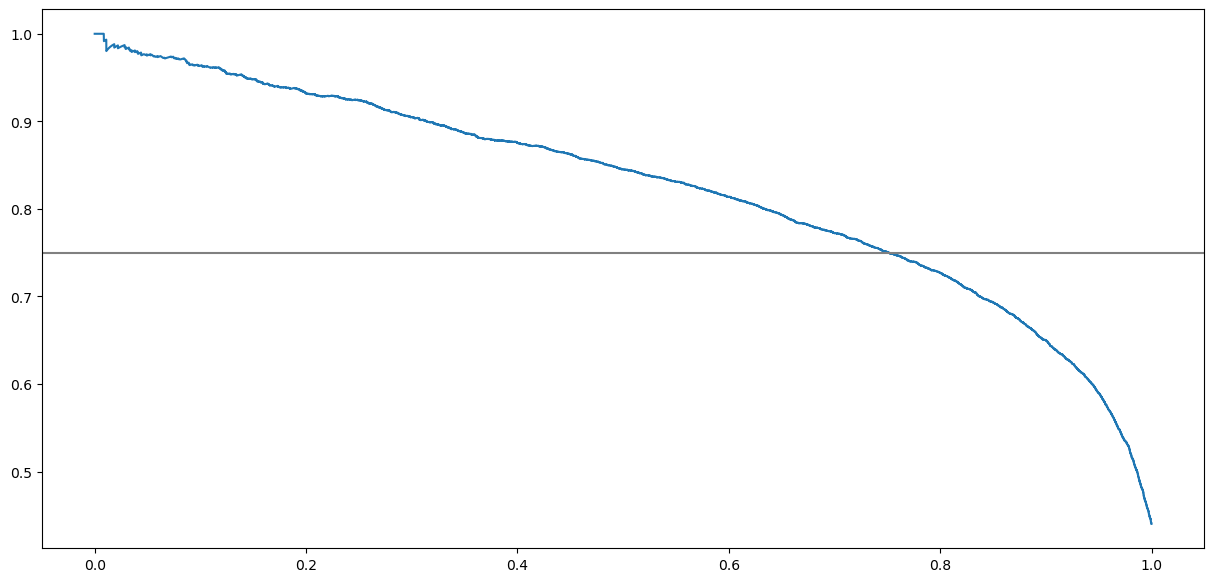

In [70]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

### Submission

In [76]:
test_data = pd.read_csv(r"C:\Users\Lawye\YandexDisk\jupyter\hackaton\test_data_prepared_normal.csv", encoding="utf-8-sig")

In [77]:
test_data.head(5)

,Unnamed: 0,unique,variantid1,variantid2,cat3,cat3_grouped,Count_vec Similarity_characteristic_attributes_mapping,TF-idf Similarity_characteristic_attributes_mapping,Count_vec Similarity_name,TF-idf Similarity_name,Count_vec Similarity_categories,TF-idf Similarity_categories,Count_vec Similarity_color_parsed,TF-idf Similarity_color_parsed,Count_vec Similarity_all_text,TF-idf Similarity_all_text,similarity_main_pic_embeddings_resnet_v1,similarity_pic_embeddings_resnet_v1,similarity_name_bert_64
0,0,52076340290590137,52076340,290590137,Батарейки и аккумуляторы,rest,0.986754,0.974330,0.762770,0.620127,1.0,1.0,1.000000,1.000000,0.944444,0.901863,0.997061,0.660078,0.984255
1,1,64525522204128919,64525522,204128919,"Смартфоны, планшеты, мобильные телефоны",rest,0.961910,0.931516,0.875000,0.779915,1.0,1.0,1.000000,1.000000,0.960534,0.928581,0.776353,0.717170,0.990931
2,2,77243372479860557,77243372,479860557,Кабели и переходники,Кабели и переходники,0.668259,0.519649,0.286039,0.168657,1.0,1.0,1.000000,1.000000,0.699268,0.556533,0.994726,0.785055,0.947975
3,3,86065820540678372,86065820,540678372,Устройство ручного ввода,rest,0.859757,0.761947,0.476731,0.315785,1.0,1.0,0.000000,0.000000,0.820028,0.709859,0.881459,0.261203,0.991292
4,4,91566575258840506,91566575,258840506,"Смартфоны, планшеты, мобильные телефоны",rest,0.763913,0.648259,0.771517,0.632790,1.0,1.0,0.707107,0.579739,0.793687,0.684979,0.787680,0.943340,0.990265


In [78]:
test_data = test_data.rename(columns = {'similarity_main_pic_embeddings_resnet_v1':'cos_sim_main_pic_embeddings_resnet'})

In [79]:
submission_example = test_data.copy()

In [80]:
submission_example["target"] = model.predict_proba(submission_example[feats])[:, 1]

In [81]:
submission_example = submission_example[["variantid1", "variantid2", "target"]]

In [82]:
submission_example.drop_duplicates().merge(
    test_data[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv("submission_example_end1.csv", index=False)

In [83]:
submission_example.head(5)

,variantid1,variantid2,target
0,52076340,290590137,0.154085
1,64525522,204128919,0.223178
2,77243372,479860557,0.446810
3,86065820,540678372,0.156139
4,91566575,258840506,0.590024
